# Minimun redundancy-maximun relevance feature selection

In the present notebook, we will applied the feature selection method called minimun redundancy-maximun relevance (MRMR) for biomarker discovery (followed by gene enrichment analysis), and for dimensionality reduction to further implement ML models to differentiate between tumor and healthy breast tissue, based on microarray data available at the NIH - Gene Expression Omnibus (Superseries [GSE70951](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE70951)).

## Data extraction and correction

The GSE70951 is composed of two series:

* *Age and estrogen-dependent inflammation in breast adenocarcinoma and normal breast tissue [cohort_1]*, with the code [GSE70905](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE70905), which will be used as an external validation dataset
* *Age and estrogen-dependent inflammation in breast adenocarcinoma and normal breast tissue [cohort_2]*, with the code [GSE70947](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE70947), which will be used for biomarker discovery
We will be using the second cohort for out study.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

The data preprocessing and differential gene expression analysis was done in R using the `limma` package.

In [2]:
!gdown https://drive.google.com/uc?id=1tITWOKQoUZjQf1VgIaaKhxtHzImFH7fo
!gdown https://drive.google.com/uc?id=1ViDbGJZU6RfwDPAfhnF7gjcFeQtyg_u2

Downloading...
From: https://drive.google.com/uc?id=1tITWOKQoUZjQf1VgIaaKhxtHzImFH7fo
To: /content/GSE70947.csv
100% 176M/176M [00:00<00:00, 241MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ViDbGJZU6RfwDPAfhnF7gjcFeQtyg_u2
To: /content/GSE70947_DGE_filtered.csv
100% 296k/296k [00:00<00:00, 86.0MB/s]


The `GSE70947` file has the gene expression information. The columns are divided in
* `index`, which have the GEO code for each patient
* `type`, which has the class at which each patient belongs (either healthy or adenocarcinoma)
* the rest of the columns, that have the name of the gen an its expression level

In [3]:
gse = pd.read_csv('GSE70947.csv', index_col = 0)
gse.head()

,NM_144987,NM_013290,ENST00000322831,NM_001625,lincRNA:chr7:226042-232442_R,NM_032391,ENST00000238571,XR_108906,NM_005937,NM_152493,...,NM_152343,NM_001005327,NM_001039355,lincRNA:chr21:44456656-44468556_R,lincRNA:chr9:4869500-4896050_F,NM_016053,NM_001080425,ENST00000555638,ENST00000508993,type
GSM1823702,8.710837,7.752260,6.147044,11.330250,8.049364,4.786607,5.762913,4.673030,8.595702,10.700061,...,6.452793,4.861030,10.751960,5.231761,6.099910,10.653872,8.983922,5.117210,5.231761,healthy
GSM1823703,9.386920,7.125349,7.033364,11.043588,8.546755,5.365691,5.564553,4.966745,8.505314,10.952910,...,5.836469,3.858494,11.302093,4.003188,3.858494,10.751094,8.199526,4.085583,4.355808,healthy
GSM1823704,8.958187,7.993491,6.358601,11.548966,8.616110,5.402829,5.941259,5.093209,8.683907,10.574121,...,6.668138,3.793648,10.581576,5.137291,6.605187,10.435313,8.493851,4.669778,5.225001,healthy
GSM1823705,9.034777,7.856471,6.260612,12.290221,7.724913,4.631357,6.745727,4.840550,8.573251,10.787665,...,5.905563,4.458250,11.178242,5.123130,6.739206,11.113692,8.896214,4.358008,4.631357,healthy
GSM1823706,8.822363,7.593622,6.322608,12.204265,7.785088,4.295037,6.597042,4.366717,8.788972,10.818610,...,5.672441,4.557420,12.016128,5.110453,6.496323,10.913592,9.536360,4.673507,4.557420,healthy


The `DGE` file contains the results of the differential gene expression, considering a $\log |\text{FC}| > 1$ and $\text{adj.P-val} < 0.05$ as thresholds

In [4]:
dge = pd.read_csv('GSE70947_DGE_filtered.csv', index_col = 0)
dge.head()

,ID,logFC,AveExpr,t,P.Value,adj.P.Val,B,diffexpressed
lincRNA:chr2:216585154-216585719_F,lincRNA:chr2:216585154-216585719_F,3.725171,7.142946,16.750688,1.316560e-44,3.454359e-40,90.700821,UP
NM_006086,NM_006086,3.048427,7.739344,16.663225,2.786762e-44,3.454359e-40,89.958877,UP
NM_004456,NM_004456,1.699635,7.972860,16.625759,3.842303e-44,3.454359e-40,89.641072,UP
NM_002141,NM_002141,-1.344960,7.782020,-16.404438,2.561246e-43,1.726984e-39,87.764022,DOWN
lincRNA:chr4:89637527-89646627_R,lincRNA:chr4:89637527-89646627_R,-1.904182,7.375651,-16.067836,4.577865e-42,2.469392e-38,84.910909,DOWN


Extracting the target,

In [5]:
from sklearn.preprocessing import LabelEncoder
y = gse["type"]
y = LabelEncoder().fit_transform(y)

and storing the data in the variable `X`.

In [6]:
X = gse.drop(["type"], axis = 1)
X = X[np.array(dge["ID"])]
X.head()

,lincRNA:chr2:216585154-216585719_F,NM_006086,NM_004456,NM_002141,lincRNA:chr4:89637527-89646627_R,NM_014736,NM_005480,NM_016359,NM_004336,NM_001083961,...,NM_001178126,NP113779,S77011,ENST00000498435,NM_002411,A_33_P3251412,NM_012188,NM_006552,NM_006551,NM_002652
GSM1823702,4.786607,6.321416,6.808873,8.685651,9.205305,5.675846,6.558804,6.124203,4.509872,7.197222,...,13.480088,9.728459,12.696556,9.518063,7.363144,9.754804,5.468174,7.310242,7.644311,8.949257
GSM1823703,7.644079,9.365653,7.938209,7.063652,7.311140,7.116449,7.892767,7.016965,4.633230,8.543367,...,13.369119,10.337995,12.618046,10.213340,12.581711,8.704484,6.232431,11.249700,11.713772,13.530426
GSM1823704,4.687383,4.830394,6.870517,8.485212,10.360521,5.066081,6.646007,4.805947,3.501254,7.634662,...,10.077759,6.817671,9.302829,6.409630,3.621975,6.006907,1.449203,4.598337,4.635677,4.456936
GSM1823705,5.097593,5.676941,7.078230,8.328697,9.077607,5.916410,6.553197,5.758328,4.256620,7.382161,...,13.854754,11.696181,12.933871,10.968928,11.478130,9.929380,8.450231,11.012945,11.134689,12.588631
GSM1823706,5.012687,5.626693,7.558369,8.562031,9.844757,6.741824,6.729353,6.239319,5.328063,7.545784,...,17.035073,14.224910,16.074557,13.696180,16.456441,13.741491,7.200912,15.944112,15.928179,17.924073


## MRMR feature selection

The implementation was done using the `PymRMRe` package from the [CMBP](https://cbmp.ca/software)

In [7]:
!pip install numpy Cython
!pip install -U pymrmr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.5/69.5 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pymrmr: filename=pymrmr-0.1.11-cp310-cp310-linux_x86_64.whl size=352645 sha256=0595d7b80408467525bdbea30910ffd381eb67a0006eaad6773b1cd5be5411b4
  Stored in directory: /root/.cache/pip/wheels/46/ae/55/4a2479c5f0de7eb363fe970cb18e4a750e03e4e63b1b5c2005
Successfully built pymrmr


To determine the optimal parameters of the `pymrmr` method, we will do a cross validation using a Logistic Regression model.

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.33,
                                                    random_state = 42)

We will use first the MIQ (mutual information quotient) as the feature selection scheme.

In [9]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import pymrmr

results_mrmr = {'# features': [], '5-fold score': []}
n_features = [2,5,10,15,20]
cv = StratifiedKFold(n_splits=5)

best = 0
best_features = None

for i, n_feat in enumerate(n_features):
  selected_features = pymrmr.mRMR(X_train, 'MIQ', n_feat)

  # Training set with selected features
  X_mrmr = X_train[selected_features]

  # 5-fold cross validation
  lr = LogisticRegression()
  scores = cross_val_score(lr, X_mrmr, y_train, cv=cv)

  # Store results
  results_mrmr['# features'].append(len(selected_features))
  results_mrmr['5-fold score'].append(f'{scores.mean():.3f}±{scores.std():.3f}')

  if scores.mean() > best :
    best = scores.mean()
    best_features = selected_features


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Analyzing the results,

In [10]:
results_mrmr = pd.DataFrame(results_mrmr)
results_mrmr

,# features,5-fold score
0,2,0.778±0.079
1,5,0.835±0.078
2,10,0.866±0.044
3,15,0.861±0.050
4,20,0.840±0.063


Now, we repeat the same procedure for the MID (mutual information difference) scheme.

In [11]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import pymrmr

results_mrmr = {'# features': [], '5-fold score': []}
n_features = [2,5,10,15,20]
cv = StratifiedKFold(n_splits=5)

for i, n_feat in enumerate(n_features):
  selected_features = pymrmr.mRMR(X, 'MID', n_feat)

  # Training set with selected features
  X_mrmr = X_train[selected_features]

  # 5-fold cross validation
  lr = LogisticRegression()
  scores = cross_val_score(lr, X_mrmr, y_train, cv=cv)

  # Store results
  results_mrmr['# features'].append(len(selected_features))
  results_mrmr['5-fold score'].append(f'{scores.mean():.3f}±{scores.std():.3f}')

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Analyzing the results,

In [12]:
results_mrmr = pd.DataFrame(results_mrmr)
results_mrmr

,# features,5-fold score
0,2,0.809±0.087
1,5,0.819±0.071
2,10,0.825±0.046
3,15,0.820±0.058
4,20,0.840±0.049


Since both yield different performance metrics, we will choose the one that uses less features.

In [18]:
X = X[best_features]

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.33,
                                                    random_state = 42)

Analyzing gene expression,

In [14]:
# biomarkers = X

# plt.figure(figsize = (8,7))

# for n, bio in enumerate(biomarkers):
#   ax = plt.subplot(4,5, n+1)

#   sns.boxplot(x = 'type', y = bio, data = gse, ax = ax)
#   ax.set_xticklabels(['healthy', 'adenocarcinoma'])

#   plt.title(bio)

# plt.tight_layout()
# plt.show()

## Machine learning models

Exploring the pairwise relationship between genes.

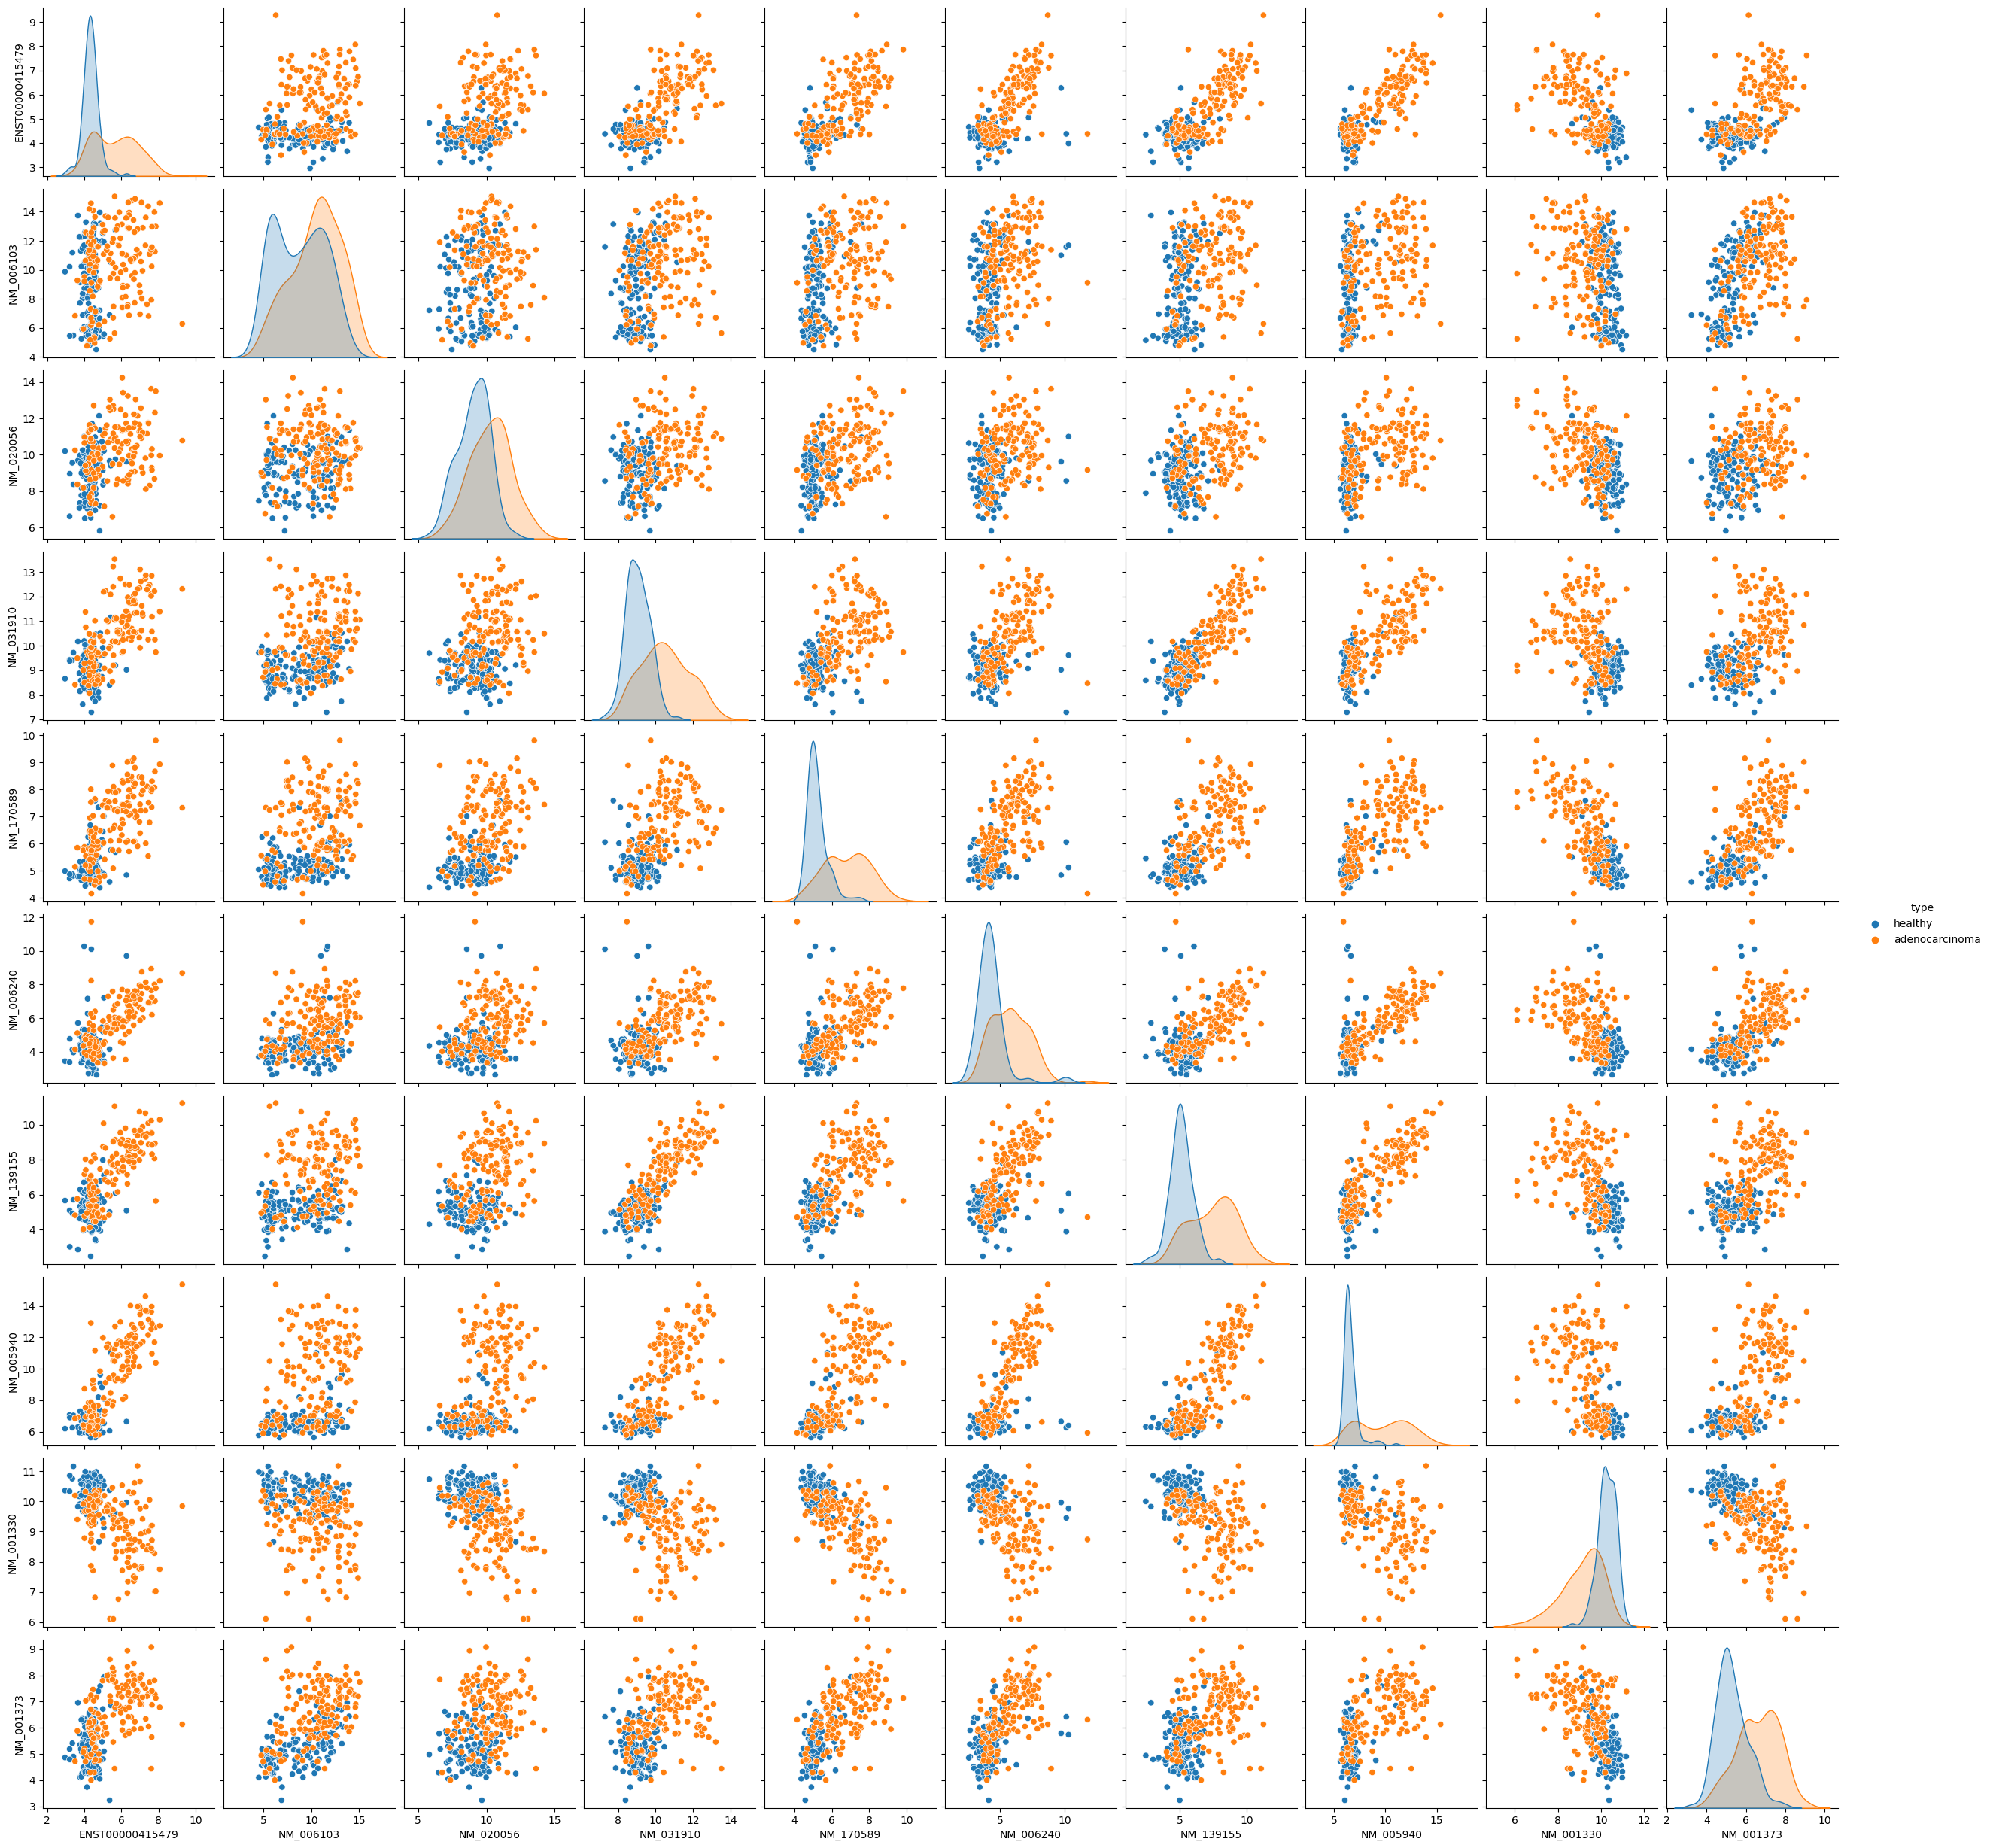

In [17]:
df_aux =X.loc[:]
df_aux['type'] = gse['type']
sns.pairplot(df_aux, hue = "type")

Exporting the selected genes

In [19]:
# Exporting the identified genes
with open('MRMR_genes.txt', 'w') as my_file:
      for genei in best_features:
          my_file.write(genei + '\n')

In [20]:
#@title Classification

clf = []

# Utilizaremos GridSearch para obtener los mejores parámetros para cada clasificador
from sklearn.model_selection import GridSearchCV

# Dummy classifier for baseline
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent")
clf.append(dummy_clf)

# Logistic Regression
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression()
clf.append(lr_clf)

# Support Vector Machine
from sklearn.svm import SVC

param_grid = {'kernel': ['linear', 'poly', 'rbf'],
              'C': [0.1, 1, 10, 100],
              'gamma': [1, 0.1, 0.001, 0.0001]}

svm_clf = SVC()
svm_GS = GridSearchCV(svm_clf, param_grid)
clf.append(svm_GS)

# Random Forest
from sklearn.ensemble import RandomForestClassifier

param_grid = {'n_estimators': [10,50,100,200, 1000],
              'min_weight_fraction_leaf': [0.0, 0.5],
              'max_features': ['sqrt', 'log2']
              }

rf_clf = RandomForestClassifier()
rf_GS = GridSearchCV(rf_clf, param_grid)
clf.append(rf_GS)

# K-nearest neighbors
from sklearn.neighbors import KNeighborsClassifier

param_grid = {'n_neighbors': np.arange(5,21),
              }

knn_clf = KNeighborsClassifier()
knn_GS = GridSearchCV(knn_clf, param_grid)
clf.append(knn_GS)

from xgboost import XGBClassifier

param_grid = {'gamma': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4],
              'learning_rate': [0.01, 0.03, 0.06, 0.1],
              'max_depth': [5,6,7,8],
              'n_estimators': [50,65,80,100,115,130,150],
              }

xgb_clf = XGBClassifier(objective="binary:logistic")
xgb_GS = GridSearchCV(xgb_clf, param_grid)
clf.append(xgb_GS)

# Fit
for model in clf:
  model.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [21]:
#@title Performance metrics
y_pred = [model.predict(X_test) for model in clf]
labels = ["Dummy Classifier", "Logistic regression", "SVM", "Random Forest", "KNN", "XGBoost"]
metrics = {'Accuracy':list(), 'F1 score':list(), 'Precision':list(), 'Recall':list()}

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

for j in range(len(y_pred)):
  metrics['Accuracy'].append(accuracy_score(y_test, y_pred[j]))
  metrics['F1 score'].append(f1_score(y_test, y_pred[j],))
  metrics['Precision'].append(precision_score(y_test, y_pred[j],))
  metrics['Recall'].append(recall_score(y_test, y_pred[j],))

df_metrics = pd.DataFrame(metrics)
df_metrics.insert(0, 'Clasificadores', labels)
df_metrics.set_index('Clasificadores', inplace=True)
print(df_metrics)

                     Accuracy  F1 score  Precision    Recall
Clasificadores                                              
Dummy Classifier     0.447917  0.000000   0.000000  0.000000
Logistic regression  0.822917  0.838095   0.846154  0.830189
SVM                  0.833333  0.846154   0.862745  0.830189
Random Forest        0.843750  0.854369   0.880000  0.830189
KNN                  0.802083  0.819048   0.826923  0.811321
XGBoost              0.864583  0.878505   0.870370  0.886792


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


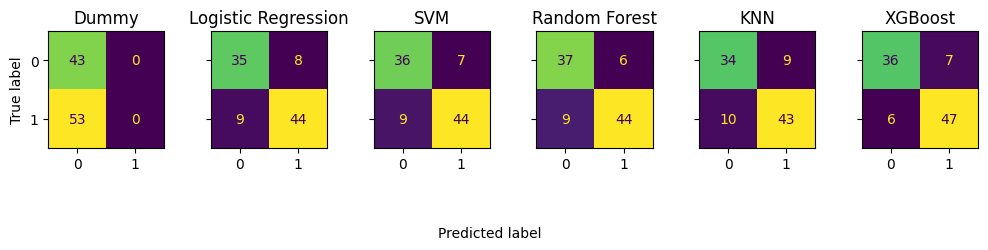

In [22]:
#@title Confusion matrix

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
labels = ['Dummy', 'Logistic Regression', 'SVM', 'Random Forest', 'KNN', 'XGBoost']

f, axes = plt.subplots(1, 6, figsize=(12, 5), sharey='row')

for i in range(6):
    cf_matrix = confusion_matrix(y_test, y_pred[i])
    disp = ConfusionMatrixDisplay(cf_matrix,)
    disp.plot(ax=axes[i],)
    disp.ax_.set_title(labels[i])
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i!=0:
        disp.ax_.set_ylabel('')

f.text(0.45, 0.2, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)

plt.show()